In [123]:
from pathlib import Path
import warnings
import os
import torch.nn as nn
from captum.attr import IntegratedGradients
import torch as ch
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
from distribution_inference.attacks.utils import get_dfs_for_victim_and_adv
from distribution_inference.attacks.whitebox.utils import get_attack, wrap_into_loader
from distribution_inference.attacks.whitebox.affinity.utils import get_loader_for_seed_data
from distribution_inference.config import DatasetConfig, AttackConfig, WhiteBoxAttackConfig, TrainConfig
from distribution_inference.utils import flash_utils, warning_string
from distribution_inference.logging.core import AttackResult

In [2]:
load_config = Path("./cel_AMC_interp.json")
meta_path = "/p/adversarialml/as9rw/tmp/celeba/Male"

In [3]:
attack_config: AttackConfig = AttackConfig.load(
        load_config, drop_extra_fields=False)
wb_attack_config: WhiteBoxAttackConfig = attack_config.white_box
train_config: TrainConfig = attack_config.train_config
data_config: DatasetConfig = train_config.data_config
if train_config.misc_config is not None:
        # TODO: Figure out best place to have this logic in the module
    if train_config.misc_config.adv_config:
            # Scale epsilon by 255 if requested
        if train_config.misc_config.adv_config.scale_by_255:
            train_config.misc_config.adv_config.epsilon /= 255
if len(attack_config.values) != 1:
        warnings.warn(warning_string(
            "\nTesting one meta-classifier against multiple ratios.\n"))
values_to_test = [str(x) for x in attack_config.values]
folders = os.listdir(meta_path)
for value in values_to_test:
    if value not in folders:
        raise ValueError(
            f"No model found for value {value} in {meta_path}")
#flash_utils(attack_config)
ds_wrapper_class = get_dataset_wrapper(data_config.name)

    # Get dataset info object
ds_info = get_dataset_information(data_config.name)()

    # Create new DS object for both and victim
_, data_config_vic_1 = get_dfs_for_victim_and_adv(
        data_config)
ds_vic_1 = ds_wrapper_class(data_config_vic_1, skip_data=True)

In [4]:
#n_vic_models = attack_config.num_victim_models
n_vic_models = 100

models_vic_1 = ds_vic_1.get_models(
            train_config,
            n_models=n_vic_models,
            on_cpu=attack_config.on_cpu,
            shuffle=True,
            model_arch=attack_config.victim_model_arch,
            custom_models_path=None,)

# For each value (of property) asked to experiment with
for i, prop_value in enumerate([attack_config.values[0]]):
    # Creata a copy of the data config, with the property value
    # changed to the current value
    _, data_config_vic_2 = get_dfs_for_victim_and_adv(
                data_config, prop_value=prop_value)

    # Create new DS object for both and victim (for other ratio)
    ds_vic_2 = ds_wrapper_class(data_config_vic_2, skip_data=True)

    # Load victim's model for other value
    models_vic_2 = ds_vic_2.get_models(
                train_config,
                n_models=n_vic_models,
                on_cpu=attack_config.on_cpu,
                shuffle=True,
                model_arch=attack_config.victim_model_arch,
                custom_models_path=None)

    # Generate test set
    test_data = wrap_into_loader(
                [models_vic_1, models_vic_2],
                batch_size=wb_attack_config.batch_size,
                shuffle=True,
                wrap_with_loader=False
            )

    # Look at all models
    attack_model_path_dir = os.path.join(
                meta_path, str(prop_value))
    for attack_model_path in [os.listdir(attack_model_path_dir)[1]]:
        # Skip if directory
        if os.path.isdir(os.path.join(attack_model_path_dir, attack_model_path)):
                    continue

        # Create attacker object
        attacker_obj = get_attack(wb_attack_config.attack)(
                    None, wb_attack_config)

        # Load model
        attacker_obj.load_model(os.path.join(
                    attack_model_path_dir, attack_model_path))
        
        # Make seed-data loader for this attack
        seed_data_loader = get_loader_for_seed_data(
                    attacker_obj.seed_data_ds, wb_attack_config)
        # Create affinity features
        features_test = attacker_obj.make_affinity_features(
                    test_data[0], seed_data_loader)


Loading models:   2%|███                                                                                                                                                    | 2/100 [00:00<00:05, 17.46it/s]

Available models: 100


Loading models:   1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.76it/s]

Available models: 100


Building affinity matrix: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.93it/s]


In [5]:
class Wrapper(nn.Module):
    def __init__(self,amc):
        super().__init__()
        self.amc = amc

    def forward(self, *args):
        # Wrap args into one list
        return self.amc(args)

w = Wrapper(attacker_obj.model)

In [6]:
def collate_fn(data):
    features, labels = zip(*data)
    # Combine them per-layer
    x = [[] for _ in range(len(features[0]))]
    for feature in features:
        for i, layer_feature in enumerate(feature):
            x[i].append(layer_feature)

    x = [ch.stack(x_, 0) for x_ in x]
    y = ch.tensor(labels).float()

    return x, y

class BasicDataset(ch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create laoaders out of all the given data
def get_loader(data, shuffle):
    ds = BasicDataset(data[0], data[1])
    return ch.utils.data.DataLoader(
        ds, batch_size=wb_attack_config.batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle)

In [7]:
test_loader_ = get_loader((features_test, test_data[1]), True)
data = next(iter(test_loader_))[0]
data = [x.cuda().requires_grad_() for x in data]

In [8]:
ig = IntegratedGradients(w)
test_input_tensor = data
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute((*test_input_tensor,),
                           target=0,
                           return_convergence_delta=True)
#attr = attr.cpu().detach().numpy()
attr = [x.cpu().detach().numpy() for x in attr]
attr_single = attr[-1]

In [66]:
# Try layer attribution to see which layers seem to be most helpful
ig = LayerIntegratedGradients(w)
test_input_tensor = data
#test_input_tensor.requires_grad_()
attr_layer, delta_layer = ig.attribute((*test_input_tensor,),
                           target=0,
                           return_convergence_delta=True)
#attr = attr.cpu().detach().numpy()
print(attr_layer)

TypeError: __init__() missing 1 required positional argument: 'layer'

In [9]:
attr = attr[:4]
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#plt.figure(dpi=1200)
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    #print(title)
    # for i in range(len(feature_names)):
        # print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

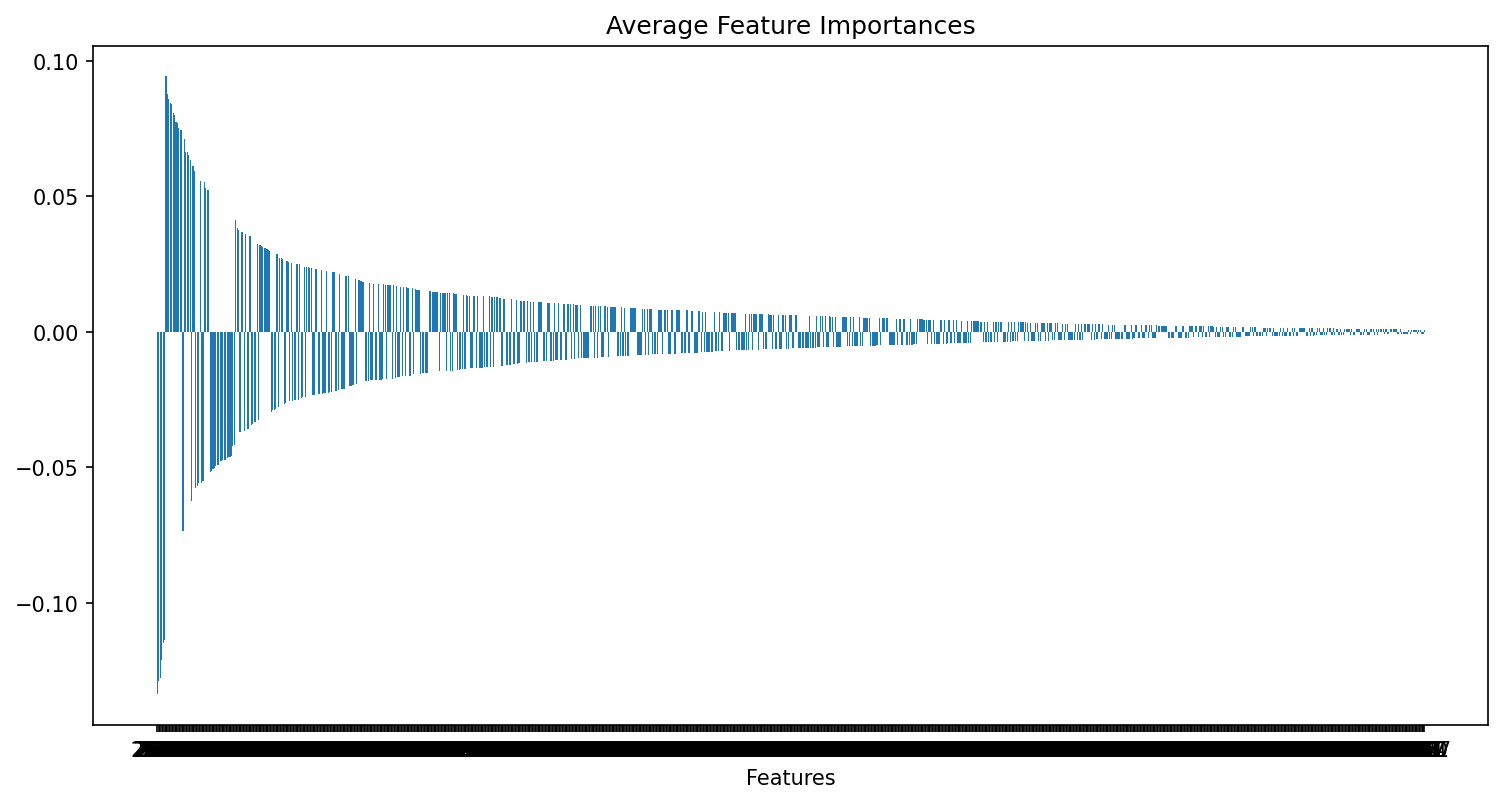

In [154]:
means = np.mean(np.mean(attr,axis=0), axis=0)
# means = np.median(np.median(attr,axis=0), axis=0)

n_look_at = int(0.9*len(means))

ind = np.argsort(np.absolute(means))[::-1][:n_look_at]
# ind = np.argsort(np.absolute(means))[::-1][-n_look_at:]
visualize_importances(attacker_obj.retained_pairs[ind], means[ind])

In [146]:
# Look at attributes for just the model logits
# Seem close to 0 - model seems to not be utilizing them at all

# means = np.mean(attr_single,axis=0)
# print(means.shape)
# ind = np.argsort(np.absolute(means))[::-1]
# visualize_importances(np.arange(attr_single.shape[1]), means[ind])

In [155]:
print(len(ind))
def reverse_ind(x, leng):
#get the indexes of points from the index of pairs, x. leng is # of points
    indices_i, indices_j = [], []
    f = np.arange(leng)
    for j in f[:-1]:
        others = f[j+1:]
        indices_i += [j] * len(others)
        indices_j += list(range(j+1, leng))
    indices_i = np.array(indices_i)
    indices_j = np.array(indices_j)
    return (indices_i[x], indices_j[x])

891


In [156]:
def sigmoid(x):
    exp = np.exp(x)
    return exp / (1 + exp)

In [157]:
p_ind = reverse_ind(attacker_obj.retained_pairs[ind],len(attacker_obj.seed_data_ds))
"""
pis = attacker_obj.seed_data_ds[p_ind[0]].cuda()
pjs = attacker_obj.seed_data_ds[p_ind[1]].cuda()

pred_i = (sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_2])))
pred_j = (sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_2])))
"""
print()

89
(100, 89, 1)


Text(0, 0.5, 'Average prediction from models on D1')

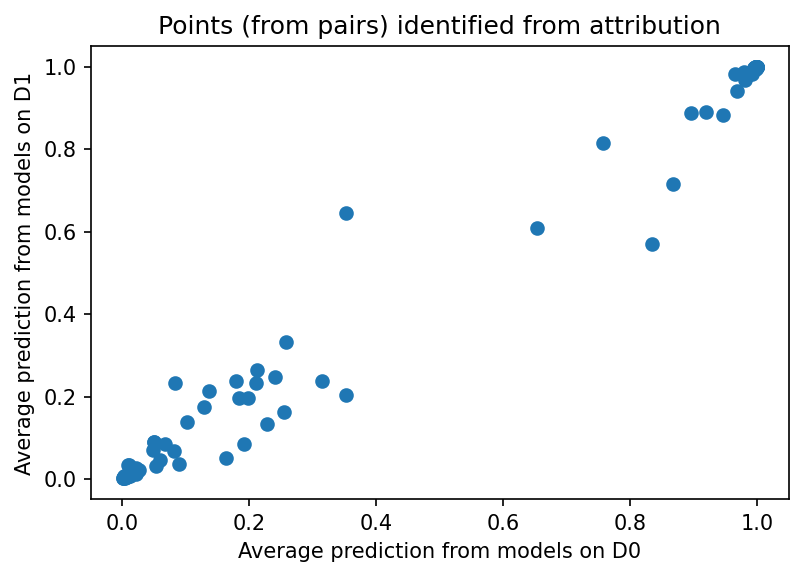

In [158]:
uni_p = np.unique(np.concatenate(p_ind))
ps = attacker_obj.seed_data_ds[uni_p].cuda()
preds = [sigmoid(np.array([m.cuda().eval()(ps).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(ps).cpu().detach().numpy() for m in models_vic_2]))]
print(len(uni_p))
print(preds[0].shape)
preds = [np.mean(x,0) for x in preds]
plt.scatter(preds[0],preds[1])
plt.title("Points (from pairs) identified from attribution")
plt.xlabel("Average prediction from models on D0")
plt.ylabel("Average prediction from models on D1")

In [159]:
pis = attacker_obj.seed_data_ds[p_ind[0]].cuda()
pjs = attacker_obj.seed_data_ds[p_ind[1]].cuda()

pred_i = (sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_2])))
pred_j = (sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_2])))
pred_i = [np.mean(x,0) for x in pred_i]
pred_j = [np.mean(x,0) for x in pred_j]


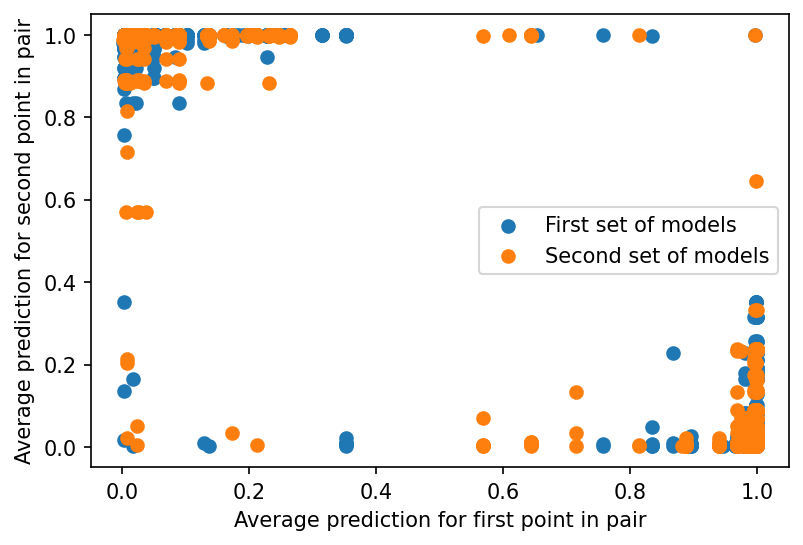

In [160]:
plt.scatter(pred_i[0],pred_j[0], label="First set of models")
plt.scatter(pred_i[1],pred_j[1], label="Second set of models")
plt.xlabel("Average prediction for first point in pair")
plt.ylabel("Average prediction for second point in pair")
plt.legend()

Total percentage of edges between two colors: 97.76%
Total percentage of edges within first color: 0.79%
Total percentage of edges within second color: 1.46%


Total percentage of edges with one of them as anchor: 49.72%


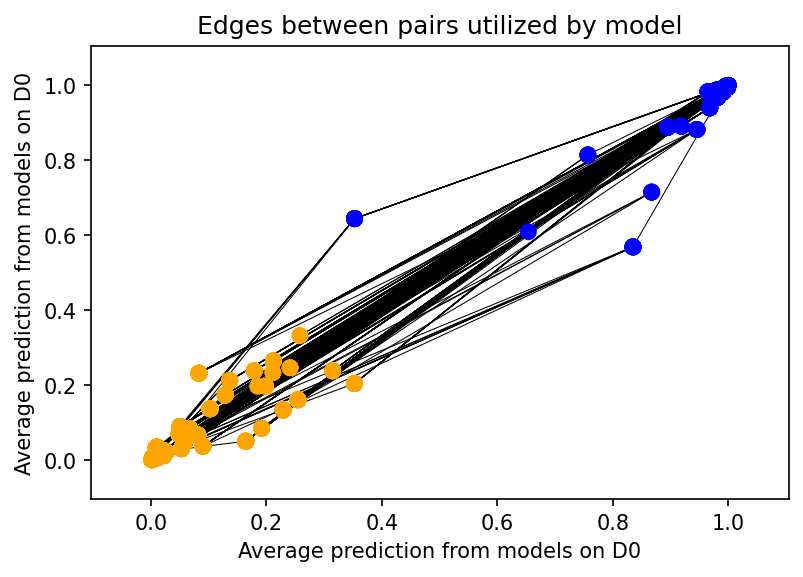

In [161]:
import networkx  as nx
G=nx.Graph()

large_num = int(1e5)
fig, ax = plt.subplots()
node_color_list = []

def add_to_flow(p, q):
    if p < 0.5 and q < 0.5:
        return True
    return False

def lower_left_quad(p, q):
    if add_to_flow(p, q):
        return 'orange'
    return 'blue'

def anchor_point(p, q):
    if np.abs(p - q) < 0.01:
        return True
    return False

flow_nodes = []
one_of_them_anchor_nodes = []
for i in range(n_look_at):
    G.add_node(i,pos=(pred_i[0][i][0],pred_i[1][i][0]))
    node_color_list.append(lower_left_quad(pred_i[0][i][0],pred_i[1][i][0]))
    G.add_node(large_num-i,pos=(pred_j[0][i][0],pred_j[1][i][0]))
    node_color_list.append(lower_left_quad(pred_j[0][i][0],pred_j[1][i][0]))
    # Add orange nodes to one set
    if add_to_flow(pred_i[0][i][0],pred_i[1][i][0]):
        flow_nodes.append(i)
    if add_to_flow(pred_j[0][i][0],pred_j[1][i][0]):
        flow_nodes.append(large_num-i)
    # Also track pairs where one of the points has similar predictions for both sets of models
    # Which might correspond to a rule like 'models that have similar prediction on this, but not on that'
    anchor_1 = anchor_point(pred_i[0][i][0],pred_i[1][i][0])
    anchor_2 = anchor_point(pred_j[0][i][0],pred_j[1][i][0])
    if np.logical_xor(anchor_1, anchor_2):
        if anchor_1:
            one_of_them_anchor_nodes.append(i)
        else:
            one_of_them_anchor_nodes.append(large_num-i)

for i in range(n_look_at):
    G.add_edge(i,large_num-i)

pos=nx.get_node_attributes(G,'pos')

nx.draw_networkx(G, pos, ax=ax, with_labels=False, node_size=50, width=0.5, node_color=node_color_list)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("Average prediction from models on D0")
plt.ylabel("Average prediction from models on D0")
plt.title("Edges between pairs utilized by model")

num_edges_total = G.number_of_edges()

# Print edge boundary between the two colors
num_edges_cross = len(list(nx.edge_boundary(G, flow_nodes)))
print("Total percentage of edges between two colors: %.2f%%" % (100 * num_edges_cross / num_edges_total))
sum_so_far = num_edges_total - num_edges_cross

# Print edged within first color
num_edges_within_first = len(list(nx.edge_boundary(G, flow_nodes, flow_nodes)))
print("Total percentage of edges within first color: %.2f%%" % (100 * num_edges_within_first / num_edges_total))
sum_so_far -= num_edges_within_first

print("Total percentage of edges within second color: %.2f%%" % (100 * sum_so_far / num_edges_total))
print("\n")

# Also see how many points have one with 'anchor'
num_edges_anchor = len(list(nx.edge_boundary(G, one_of_them_anchor_nodes)))
print("Total percentage of edges with one of them as anchor: %.2f%%" % (100 * num_edges_anchor / num_edges_total))

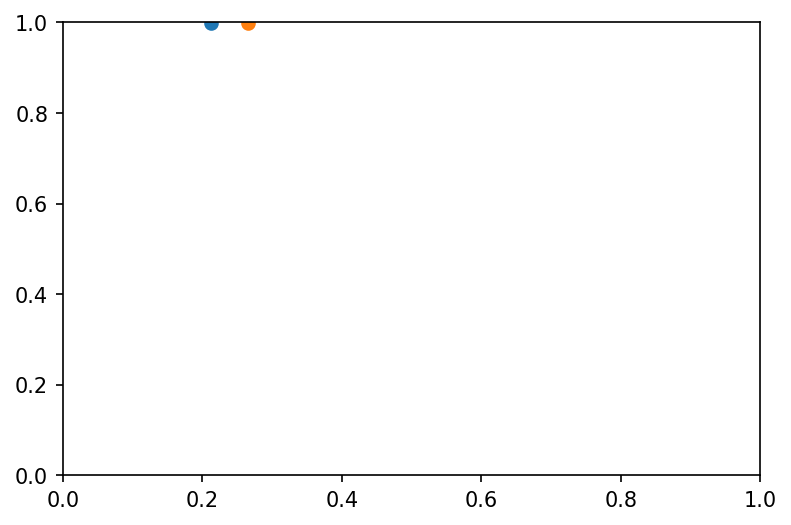

In [130]:
n=20
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(pred_i[0][n],pred_j[0][n])
plt.scatter(pred_i[1][n],pred_j[1][n])